In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Parameters
data_dir = "/Users/pavithrasenthilkumar/Documents/My_Codes/PROJECTS/Lung_Cancer_Classification_CT_Scan/artifacts/cnn_training_data"


image_size = (224, 224)
batch_size = 8
num_epochs = 5

# Load datasets
train_dataset = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

val_dataset = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

# Print class names
print("Class names:", train_dataset.class_names)  # ['lungs_ct', 'not_lungs_ct'] or vice versa

# Normalize (ImageNet-like)
normalization_layer = tf.keras.layers.Rescaling(1./255)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_dataset.map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(buffer_size=AUTOTUNE)

# Pretrained base model (ImageNet)
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

# Build the model
model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(2, activation='softmax')  # 2 classes: lungs / not-lungs
])

# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train
history = model.fit(train_ds, validation_data=val_ds, epochs=num_epochs)

# Evaluate
test_loss, test_acc = model.evaluate(val_ds)
print(f"\nTest Accuracy: {test_acc:.2f}")


Found 103 files belonging to 2 classes.
Using 83 files for training.
Found 103 files belonging to 2 classes.
Using 20 files for validation.
Class names: ['lungs_ct', 'not_lungs_ct']
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.6548 - loss: 0.6803 - val_accuracy: 0.4000 - val_loss: 0.7362
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.3579 - loss: 0.7447 - val_accuracy: 0.6000 - val_loss: 0.6517
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.6676 - loss: 0.6152 - val_accuracy: 0.6500 - val_loss: 0.6356
Epoch 4/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.7447 - loss: 0.6149 - val_accuracy: 0.6500 - val_loss: 0.6254
Epoch 5/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.7363 - loss: 0.6088 - val_accuracy: 0.6500 - val_loss: 0.6134
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 904ms/step - accuracy: 0.6531 - loss: 0.6183

Test Accuracy: 0.65


In [2]:
for images, labels in train_ds.take(1):
    print("Labels:", labels.numpy())  # e.g., [0, 1, 0, 1]
    print("Shape of images:", images.shape)


Labels: [1 1 1 0 1 1 1 1]
Shape of images: (8, 224, 224, 3)


2025-07-12 11:52:13.714350: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


#### Saving the Model

In [3]:
import os
# Save path for .h5 file (single file, great for deployment)
model_save_path = "artifacts/lung_ct_classifier_model.h5"

# Make sure the artifacts folder exists
os.makedirs("artifacts", exist_ok=True)

# Save in HDF5 format (.h5)
model.save(model_save_path)
print(f"✅ Model saved as .h5 to: {model_save_path}")


✅ Model saved as .h5 to: artifacts/lung_ct_classifier_model.h5


### Updated Code

Found 118 files belonging to 2 classes.
Class names (label mapping): ['lungs_ct', 'not_lungs_ct']
<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


2025-07-12 13:19:19.255542: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


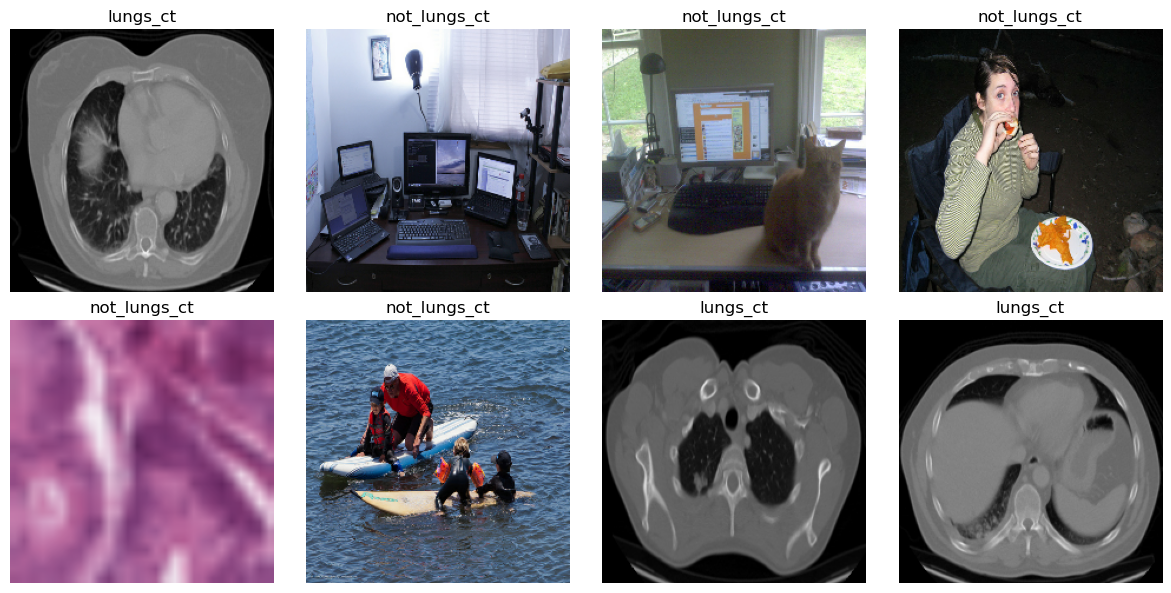

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0
from sklearn.utils import class_weight
import numpy as np
import os
import json
import matplotlib.pyplot as plt

# Parameters
data_dir = "/Users/pavithrasenthilkumar/Documents/My_Codes/PROJECTS/Lung_Cancer_Classification_CT_Scan/artifacts/cnn_training_data"
image_size = (224, 224)
batch_size = 8
num_epochs = 15
AUTOTUNE = tf.data.AUTOTUNE

# Load full dataset WITHOUT split (shuffle with seed)
full_dataset = image_dataset_from_directory(
    data_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='int',
    shuffle=True,
    seed=42,
)

# Get class names and save mapping to JSON
class_names = full_dataset.class_names
print("Class names (label mapping):", class_names)

os.makedirs("artifacts", exist_ok=True)
with open("artifacts/class_names.json", "w") as f:
    json.dump(class_names, f)

# Calculate dataset sizes
dataset_size = tf.data.experimental.cardinality(full_dataset).numpy()
test_size = int(0.1 * dataset_size)
val_size = int(0.1 * dataset_size)
train_size = dataset_size - val_size - test_size

# Split dataset
train_ds = full_dataset.take(train_size)
val_ds = full_dataset.skip(train_size).take(val_size)
test_ds = full_dataset.skip(train_size + val_size).take(test_size)


print(train_ds)

plt.figure(figsize=(12, 6))
for images, labels in train_ds.take(2):  # take 1 batch
    for i in range(len(images)):
        ax = plt.subplot(2, 4, i + 1)  # 8 images max per batch
        plt.imshow(images[i].numpy().astype("uint8"))
        label = class_names[labels[i].numpy()]
        plt.title(label)
        plt.axis("off")
plt.tight_layout()
plt.show()

# Normalization layer
normalization_layer = layers.Rescaling(1./255)

# Data augmentation only on train dataset
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

def preprocess_train(image, label):
    image = data_augmentation(image)
    image = normalization_layer(image)
    return image, label

def preprocess_val_test(image, label):
    image = normalization_layer(image)
    return image, label

train_ds = train_ds.map(preprocess_train).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.map(preprocess_val_test).cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.map(preprocess_val_test).cache().prefetch(buffer_size=AUTOTUNE)


In [19]:

# Extract labels for class weights
all_labels = np.array([y.numpy() for x, y in train_ds.unbatch()])

class_weights_arr = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)
class_weight_dict = dict(enumerate(class_weights_arr))
print("Class weights:", class_weight_dict)

# Build model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
base_model.trainable = False  # freeze base model

inputs = layers.Input(shape=(224,224,3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)
model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Initial training (frozen base)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    class_weight=class_weight_dict
)

# Fine-tune last 20 layers of base_model
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 20
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=num_epochs - 5,
    class_weight=class_weight_dict,
    callbacks=[early_stop]
)

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest accuracy on unseen data: {test_acc:.2f}")

Class weights: {0: 1.04, 1: 0.9629629629629629}
Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 813ms/step - accuracy: 0.4414 - loss: 0.7094 - val_accuracy: 0.6250 - val_loss: 0.6812
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 902ms/step - accuracy: 0.5918 - loss: 0.6920 - val_accuracy: 0.6250 - val_loss: 0.6343
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5624 - loss: 0.6815 - val_accuracy: 0.6250 - val_loss: 0.6752
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 732ms/step - accuracy: 0.5071 - loss: 0.6705 - val_accuracy: 0.6250 - val_loss: 0.6253
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 707ms/step - accuracy: 0.5886 - loss: 0.6657 - val_accuracy: 0.3750 - val_loss: 0.6786
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 993ms/step - accuracy: 0.5731 - loss: 0.6948 - val_accuracy: 0.3750 - val_loss: 0.7534
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 958ms/step - accuracy: 0.9760 - loss: 0.2787 - val_accuracy: 0.3750 - val_loss: 0.8007
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 976ms/step - acc

In [20]:
%pwd

'/Users/pavithrasenthilkumar/Documents/My_Codes/PROJECTS/Lung_Cancer_Classification_CT_Scan'

In [21]:
import os

import os

os.chdir("/Users/pavithrasenthilkumar/Documents/My_Codes/PROJECTS/Lung_Cancer_Classification_CT_Scan/")
# Save path for .h5 file (single file, great for deployment)
model_save_path = "artifacts/lung_ct_classifier_model.h5"


# Save in HDF5 format (.h5)
model.save(model_save_path)
print(f"✅ Model saved as .h5 to: {model_save_path}")

✅ Model saved as .h5 to: artifacts/lung_ct_classifier_model.h5
